## Практическое задание к уроку 8 по теме "Generative Adversarial Networks".

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

Загрузим необходимые библиотеки:

In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
RANDOM_SEED = 29

Функция, данная по заданию:

In [3]:
def func(x):
    y = np.sin(x) / x - x / 10
    return y

Посмотрим, как выглядит её график:

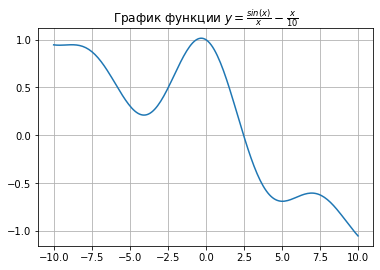

In [4]:
x_orig = np.linspace(-10, 10, 200)
y_orig = func(x_orig)

plt.plot(x_orig, y_orig)
plt.title('График функции $y = \\frac{sin(x)}{x} - \\frac{x}{10}$')
plt.grid()
plt.show()

Инициализируем генератор и дискриминатор. Генератор будет принимать  
на вход значения *x*, генерировать соответствующие им значения *y*  
и возвращать пару *x, y*. Сначала была сделана попытка генерировать  
точки на основе шума, но генератор зачастую создавал точки с одинаковыми  
значениями *x*, и на графике они все попадали в небольшую область, не  
похожую на график функции. Поэтому было принято решение брать значения *x*  
из равномерного распределения для большей наглядности результата на графике.

In [5]:
class Generator(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.lrelu(y)
        y = self.fc3(y)
        output = torch.stack((x, y), dim=1)
        return torch.squeeze(output)

Дискриминатор будет принимать пару значений *x, y* и возвращать  
вероятность того, что пара соответствует точке заданного графика.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.lrelu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

Определим класс для генерирования датасета, состоящего из точек (x, y), лежащих на  
заданном графике:

In [7]:
class Numbers(torch.utils.data.Dataset):
    def __init__(self, length):
        self.length = length
        self.data = (torch.rand((length, 1)) * 2 - 1) * 10 # генерируем равномерное распределение от -10 до 10
        self.data = torch.stack((self.data, func(self.data)), dim=1)
        self.data = torch.squeeze(self.data)
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.length

Создадим датасет и обернём его в лоадер:

In [8]:
torch.random.manual_seed(RANDOM_SEED)

data = Numbers(50000)

batch_size = 256
loader = torch.utils.data.DataLoader(data,
                                     batch_size=batch_size,
                                     shuffle=True)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Обучим нейросети. В результате генератор должен научиться создавать точки  
в двумерном пространстве, лежащие на графике заданной функции, используя  
только данные ему значения *x*.

[Epoch 1/200] [D loss: 0.6618990898132324] [G loss: 0.7402629852294922]


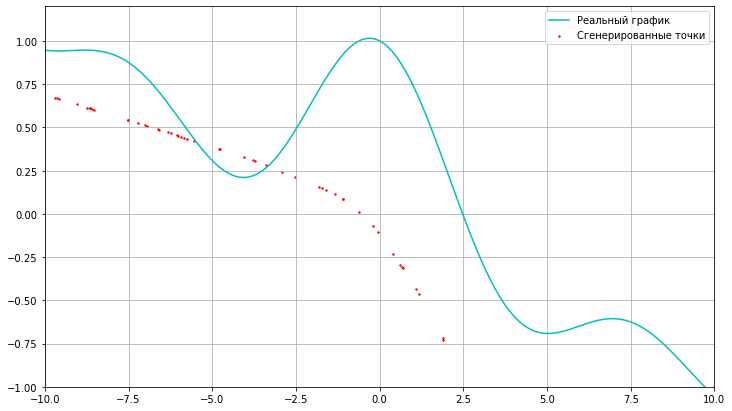

[Epoch 40/200] [D loss: 0.6913478374481201] [G loss: 0.6901053190231323]


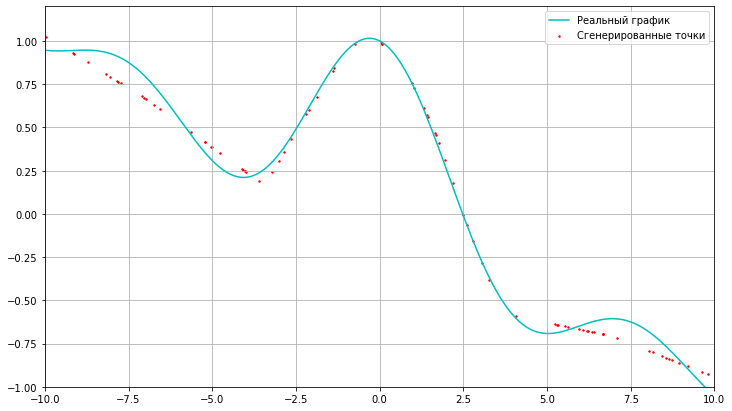

[Epoch 80/200] [D loss: 0.6944303512573242] [G loss: 0.6907727122306824]


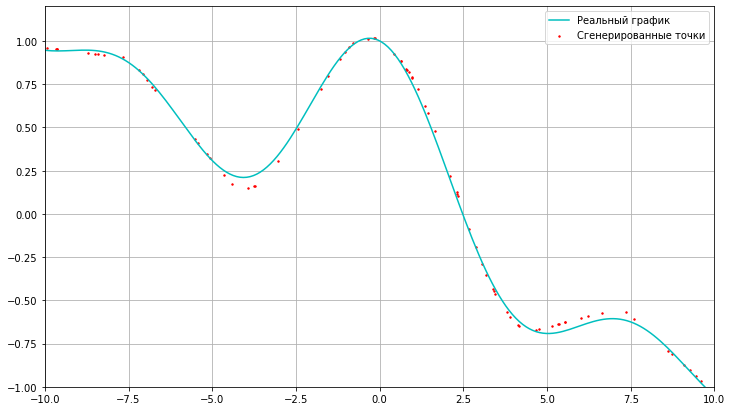

[Epoch 120/200] [D loss: 0.6939924359321594] [G loss: 0.6881762146949768]


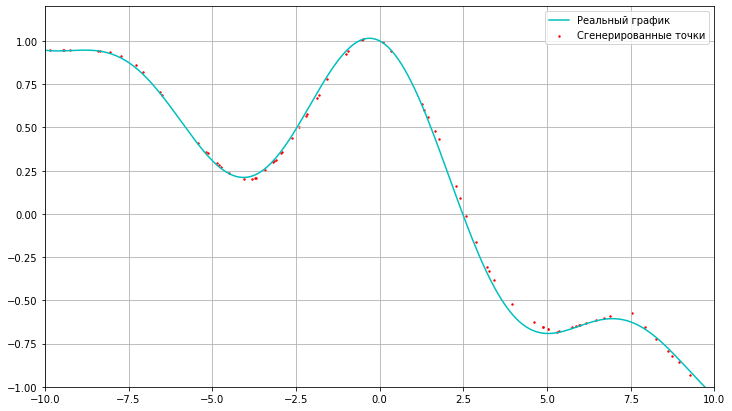

[Epoch 160/200] [D loss: 0.6920778155326843] [G loss: 0.6886760592460632]


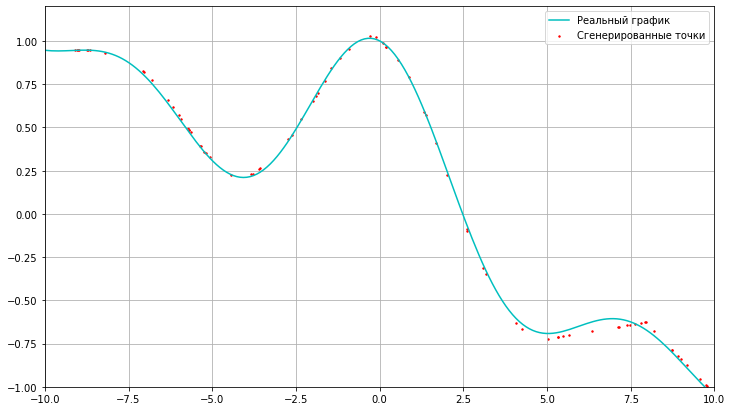

[Epoch 200/200] [D loss: 0.6936606168746948] [G loss: 0.6914149522781372]


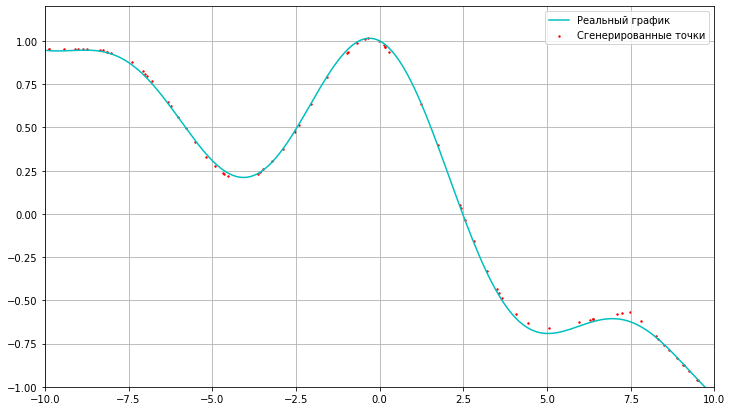

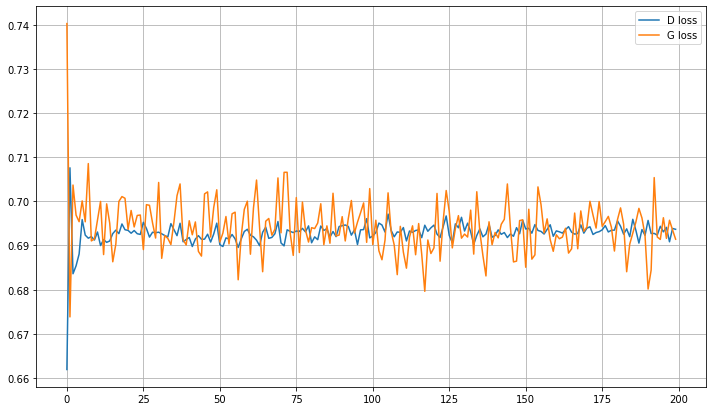

In [10]:
lr = 0.0001
epochs = 200
torch.random.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

generator = Generator(64).to(device)
discriminator = Discriminator(64).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []

for epoch in range(epochs):
    for i, xy in enumerate(loader):
        
        # Создаём векторы таргетов реальных и сгенерированных данных для дискриминатора
        real = torch.FloatTensor(len(xy), 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(len(xy), 1).fill_(0.0).to(device)

        xy = xy.to(device)

        # Генерируем вектор х
        x = ((torch.rand((len(xy), 1)) * 2 - 1) * 10).to(device)
        
        # Создаём пары x, y генератором
        gen_numbers = generator(x)

######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(xy)
        
        # Сравниваем предсказанные значения дискриминатора (на основе реальных данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, real)
        
        # Подаём сгенерированые данные на дискриминатор 
        fake_pred = discriminator(gen_numbers)
        
        # Рассчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # Усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Делаем шаг обучения дискриминатора
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # Генерируем вектор х
        x = ((torch.rand((len(xy), 1)) * 2 - 1) * 10).to(device)
        
        # Создаём пары x, y генератором
        gen_numbers = generator(x)

        # Подаём сгенерированые данные на дискриминатор 
        fake_pred = discriminator(gen_numbers)
    
        # Сравниваем предсказанные значения дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, real)
        
        # Делаем шаг обучения генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

    d_loss = d_loss.cpu().detach()
    g_loss = g_loss.cpu().detach()

    d_loss_history.append(d_loss)
    g_loss_history.append(g_loss)
    
    # Каждые 40 эпох обучения будем выводить график 
    # заданной функции и сгенерированные точки
    if epoch == 0 or (epoch+1) % 40 == 0:
        with torch.no_grad():
            # display.clear_output(wait=False)

            print(f"[Epoch {epoch+1}/{epochs}]", end=' ')
            print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

            plt.figure(figsize=(12, 7))

            plt.plot(x_orig, y_orig, label='Реальный график', c='c')
            gen_numbers = gen_numbers.cpu().detach().numpy()
            plt.scatter(gen_numbers[:, 0], gen_numbers[:, 1], s=2, c='r', label='Сгенерированные точки')
            plt.xlim(-10, 10)
            plt.ylim(-1, 1.2)
            plt.grid()
            plt.legend()
            plt.show()

# Также в конце обучения посмотрим на графики лоссов наших нейросетей
plt.figure(figsize=(12, 7))            
plt.plot(d_loss_history, label='D loss')
plt.plot(g_loss_history, label='G loss')
plt.grid()
plt.legend()
plt.show()        

Научили генератор создавать точки, лежащие на графике заданной функции.